In [2]:
%reload_ext autoreload
%autoreload 2

#Dependencies
import jax.numpy as jnp
import numpy as np
from dcegm.pre_processing.setup_model import setup_model
import jax

from typing import Tuple

import pandas as pd
import matplotlib.pyplot as plt

from dcegm.sim_interface import get_sol_and_sim_func_for_model
from dcegm.simulation.sim_utils import create_simulation_df

from scipy.optimize import minimize

import statsmodels.api as sm

import os
repo_path = os.path.abspath("../")

import sys 
sys.path.insert(0, repo_path)

from model_functions_initial.utility import utility_functions
from model_functions_initial.final_period_utility import final_period_utility
from model_functions_initial.budget import budget_dcegm_initial
from model_functions_initial.state_space_functions import create_state_space_function_dict
from model_functions_initial.compute_moments import compute_simulation_moments
from model_functions_initial.compute_moments import compute_simulation_moments_with_ci
from plots.plots import plot_empirical_vs_simulated_with_ci
from model_functions_initial.estimation import estimate_msm
from first_step.load_params import load_params_txt
from model_functions_counter.compute_counterfac import compute_counterfactual_diff
from model_functions_counter.compute_counterfac import plot_counterfactual_diff
from model_functions_counter.compute_counterfac import plot_cf_diff_separate
from model_functions_counter.compute_counterfac import compute_diff_by_edu
from model_functions_counter.compute_counterfac import plot_metrics_individual
from model_functions_counter.compute_counterfac import plot_separate_metric_panels

from model_functions_counter.budget_counter import budget_dcegm_counter_oap

from first_step.mortality import prob_survival

from dcegm.interface import validate_exogenous_processes

# ── Configurating file-location -────────────────────────────────────────────────
DATA_DIR    = repo_path + "/Data"
FILE_UDD1   = os.path.join(DATA_DIR, "momenter/moments_udd1.txt")
FILE_UDD2   = os.path.join(DATA_DIR, "momenter/moments_udd2.txt")
FILE_UDD3   = os.path.join(DATA_DIR, "momenter/moments_udd3.txt")
Mortality   = os.path.join(DATA_DIR, "mortality.xlsx")
# ────────────────────────────────────────────────────────────────────────────────

##### Git Commit Hash 47f27e8 #####
##### Git Branch = origin(aux-budget) #####
# ────────────────────────────────────────────────────────────────────────────────


jax.config.update("jax_enable_x64", True)

In [3]:
BASE = repo_path + "/oap_counterfactuals/expected"
edus = ["edu1","edu2","edu3"]

# 1) Load into dictionaries
moments = {}
for edu in edus:
    moments[edu] = {}
    init_path = os.path.join(BASE, f"moments_init_{edu}.pkl")
    cf_path   = os.path.join(BASE, f"moments_cf_{edu}.pkl")
    
    if os.path.exists(init_path):
        moments[edu]["init"] = pd.read_pickle(init_path)
    else:
        print(f"Warning: File not found: {init_path}")
        moments[edu]["init"] = pd.DataFrame()  # Initialize with an empty DataFrame
    
    if os.path.exists(cf_path):
        moments[edu]["cf"] = pd.read_pickle(cf_path)
    else:
        print(f"Warning: File not found: {cf_path}")
        moments[edu]["cf"] = pd.DataFrame()  # Initialize with an empty DataFrame

# 2) Tag & concat into one DataFrame per scenario
df_init = pd.concat(
    [moments[edu]["init"].assign(edu=edu) for edu in edus],
    ignore_index=True
)
df_cf   = pd.concat(
    [moments[edu]["cf"].assign(edu=edu)   for edu in edus],
    ignore_index=True
)


In [16]:
metrics = ["avg_hours", "avg_wealth", "avg_consumption", "prob_work"]
df_diff_all = compute_diff_by_edu(df_init, df_cf, metrics)

df_diff_all

,edu,age,avg_hours_diff,avg_hours_pct,avg_wealth_diff,avg_wealth_pct,avg_consumption_diff,avg_consumption_pct,prob_work_diff,prob_work_pct
0,edu1,30,0.407866,0.026916,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,edu1,31,0.295147,0.018898,0.000308,0.019144,0.000342,0.027737,0.000100,0.014136
2,edu1,32,0.156548,0.010000,0.000436,0.021440,0.000334,0.023625,0.000000,0.000000
3,edu1,33,-0.035941,-0.002290,0.000244,0.010501,0.000265,0.017244,0.000100,0.013353
4,edu1,34,0.000000,0.000000,0.000190,0.007494,0.000245,0.015053,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
133,edu3,71,262.103144,26.071322,3.739607,14.593387,0.140041,5.379305,0.146829,46.373971
134,edu3,72,271.076968,29.118740,4.532422,18.121733,0.132620,5.313118,0.132126,49.498328
135,edu3,73,275.924620,31.715057,5.220421,21.406500,0.123025,5.156480,0.110878,48.427673
136,edu3,74,247.550629,30.298525,5.794177,24.404699,0.112433,4.950325,0.089558,44.827586


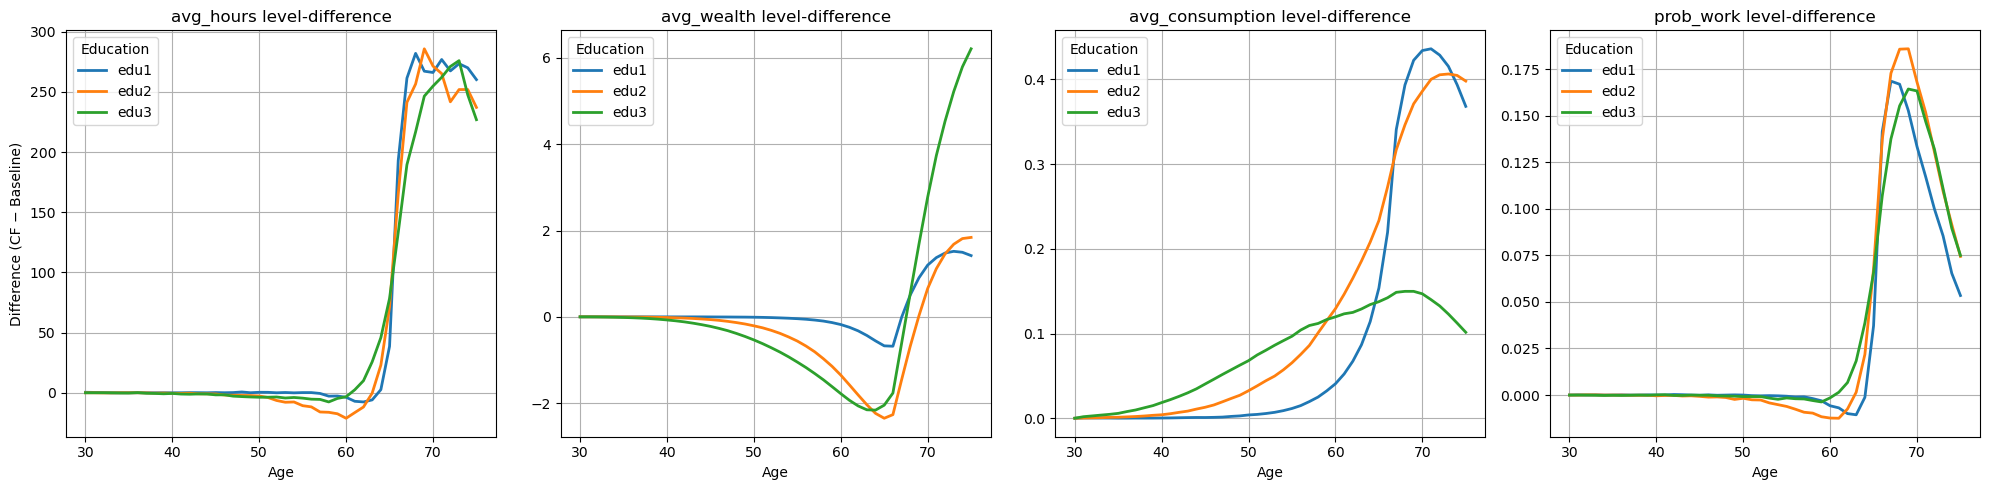

In [5]:
fig, axes = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5), sharey=False)
if len(metrics) == 1:
    axes = [axes]

for ax, m in zip(axes, metrics):
    for edu in edus:
        sub = df_diff_all[df_diff_all["edu"] == edu]
        ax.plot(sub["age"], sub[f"{m}_diff"], lw=2, label=edu)
    ax.set_title(f"{m} level‐difference")
    ax.set_xlabel("Age")
    ax.grid(True)
    ax.legend(title="Education")

axes[0].set_ylabel("Difference (CF − Baseline)")
plt.tight_layout()
plt.show()

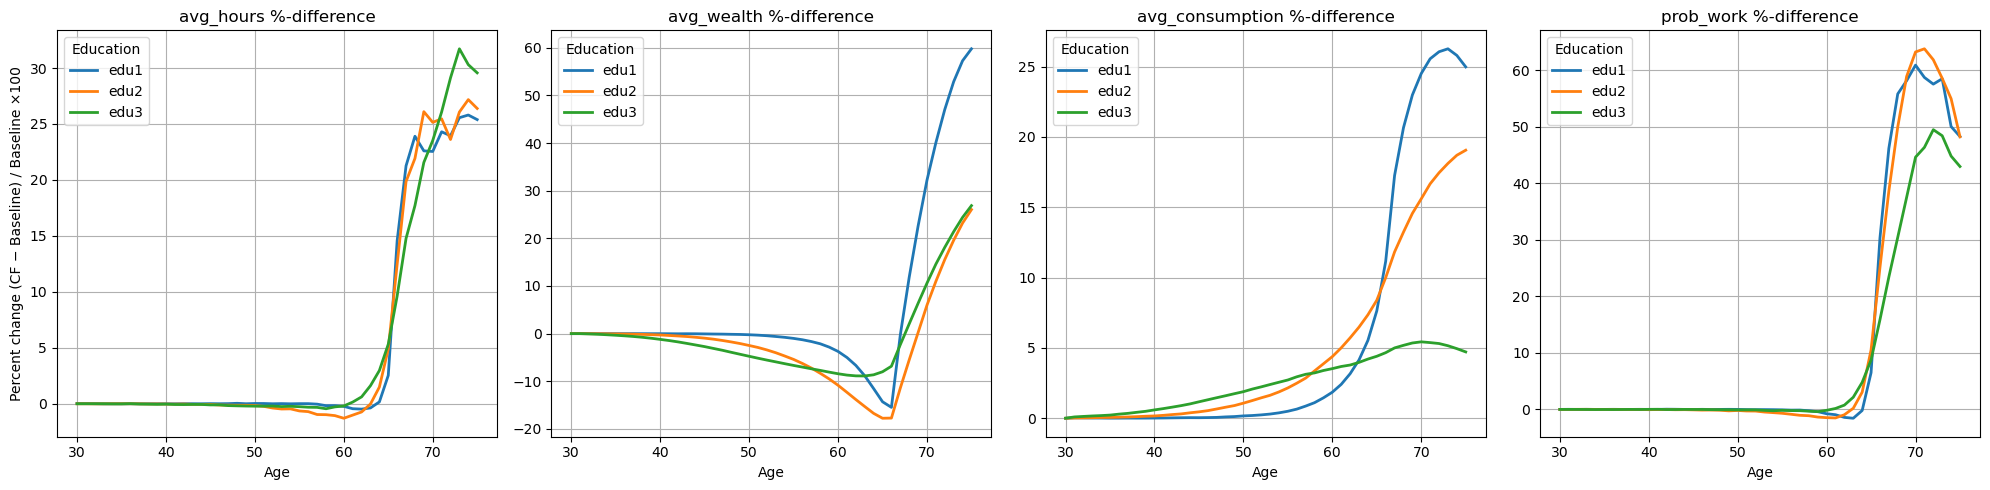

In [6]:
fig, axes = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5), sharey=False)
if len(metrics) == 1:
    axes = [axes]

for ax, m in zip(axes, metrics):
    for edu in edus:
        sub = df_diff_all[df_diff_all["edu"] == edu]
        ax.plot(sub["age"], sub[f"{m}_pct"], lw=2, label=edu)
    ax.set_title(f"{m} %‐difference")
    ax.set_xlabel("Age")
    ax.grid(True)
    ax.legend(title="Education")

axes[0].set_ylabel("Percent change (CF − Baseline) / Baseline ×100")
plt.tight_layout()
plt.show()

Saved /Users/frederiklarsen/Library/Mobile Documents/com~apple~CloudDocs/KU/Speciale/Figurer/counterfactuals/expected/avg_hours_change.png


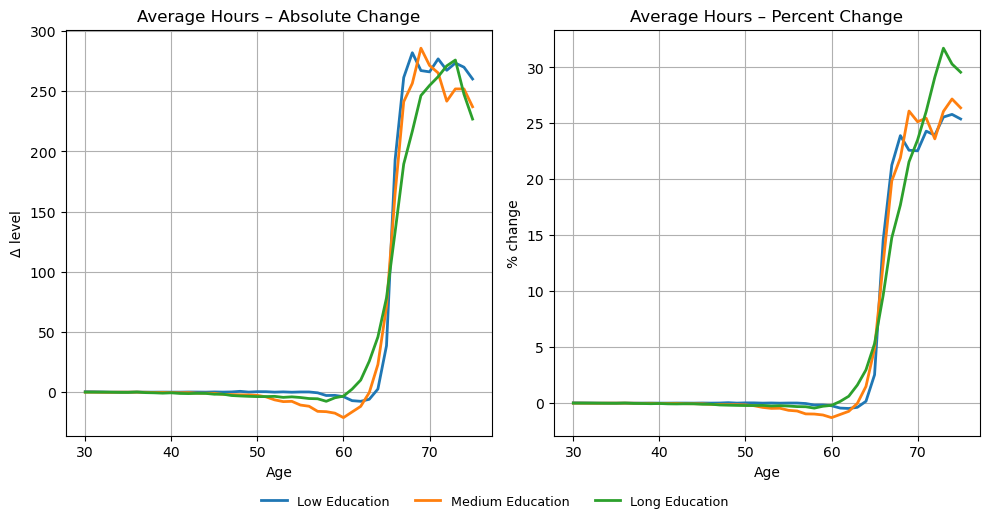

Saved /Users/frederiklarsen/Library/Mobile Documents/com~apple~CloudDocs/KU/Speciale/Figurer/counterfactuals/expected/avg_wealth_change.png


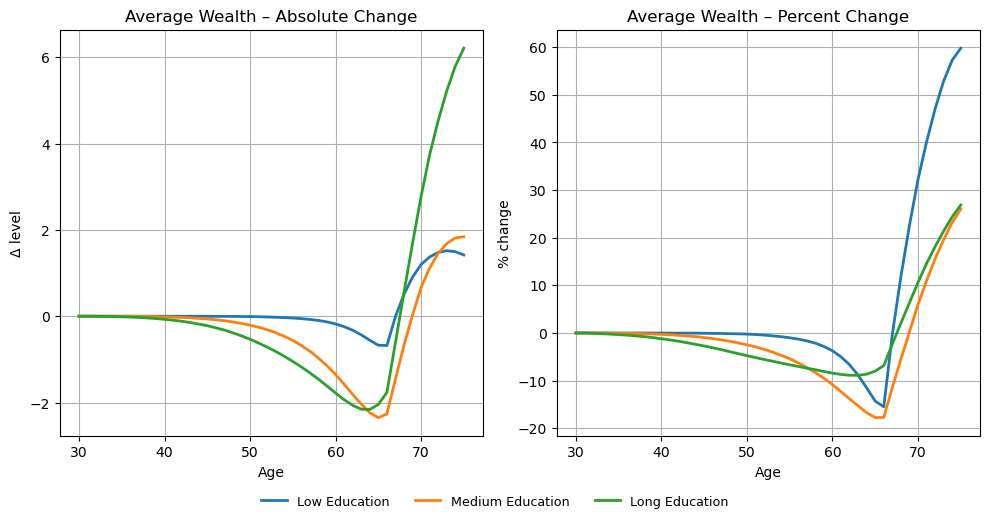

Saved /Users/frederiklarsen/Library/Mobile Documents/com~apple~CloudDocs/KU/Speciale/Figurer/counterfactuals/expected/avg_consumption_change.png


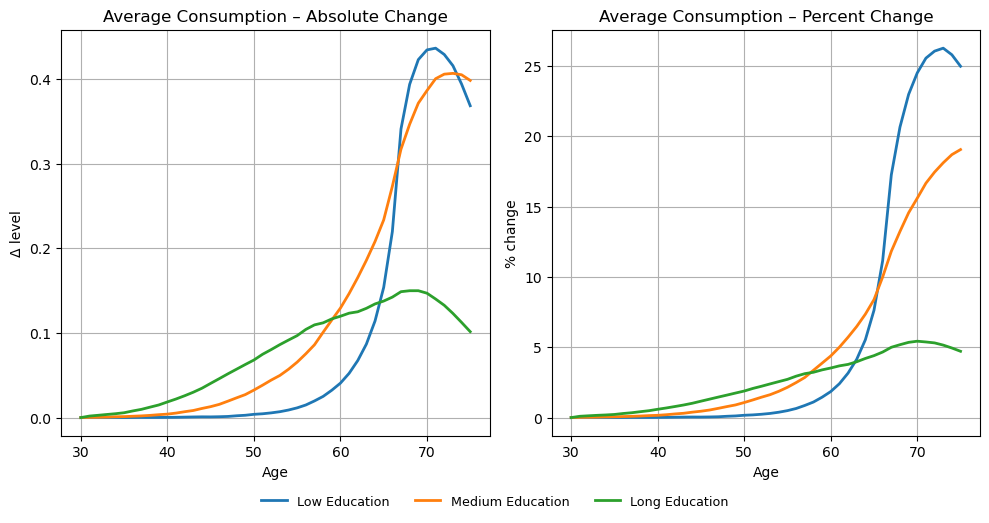

Saved /Users/frederiklarsen/Library/Mobile Documents/com~apple~CloudDocs/KU/Speciale/Figurer/counterfactuals/expected/prob_work_change.png


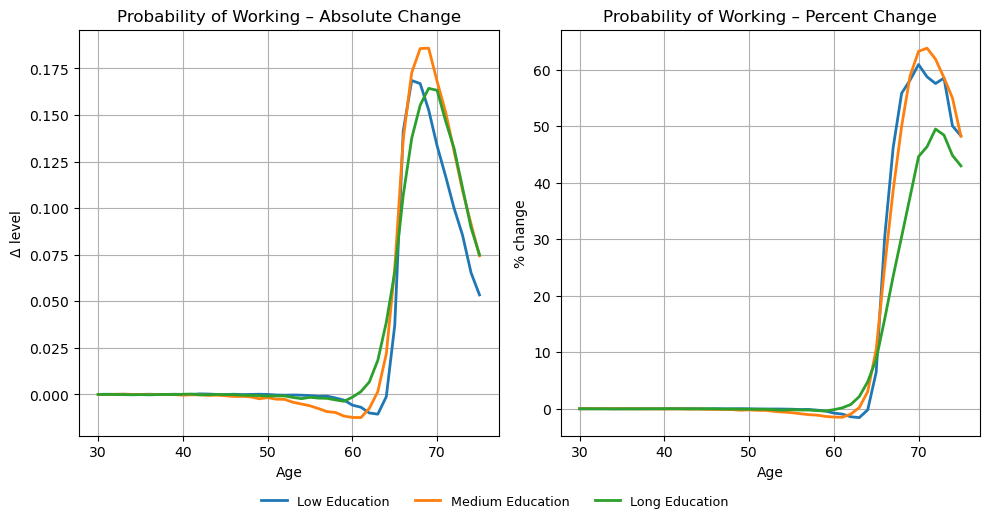

In [18]:
metric_labels = {
    "avg_hours":       "Average Hours",
    "avg_wealth":      "Average Wealth",
    "avg_consumption": "Average Consumption",
    "prob_work":       "Probability of Working"
}
edu_labels = {
    "edu1": "Low Education",
    "edu2": "Medium Education",
    "edu3": "Long Education"
}
out_fig = "/Users/frederiklarsen/Library/Mobile Documents/com~apple~CloudDocs/KU/Speciale/Figurer/counterfactuals/expected"
plot_metrics_individual(
    df_diff_all,
    metrics,
    edu_labels=edu_labels,
    metric_labels=metric_labels,
    legend_y_offset=-0.05,
    savefig=True,
    out_dir=out_fig
)



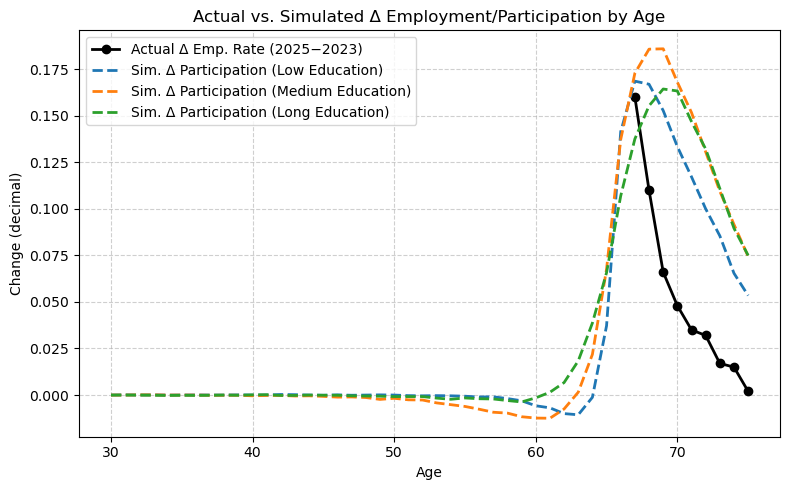

In [24]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# === ASSUMPTION: df_diff_all has columns "edu", "age", "prob_work_diff" (e.g. 0.1468) ===

# Paths
repo_path  = os.path.abspath("..")
excel_path = os.path.join(repo_path, "data", "jobindsats.xlsx")
output_dir = "/Users/frederiklarsen/Library/Mobile Documents/com~apple~CloudDocs/KU/Speciale/Figurer/counterfactuals/verify_2"

# 1) Load Excel data
df = pd.read_excel(excel_path)

# 2) Convert comma‐decimal to dot and cast to float
df["employment_rate"] = (
    df["employment_rate"]
      .astype(str)
      .str.replace(",", ".")
      .astype(float)
)

# 3) Clean up age labels: map '75+' → 75, then to int
df["age_numeric"] = df["age"].replace({"75+": "75"}).astype(int)

# 4) Pivot so years become columns, indexed by numeric age
df_pivot = df.pivot(index="age_numeric", columns="year", values="employment_rate")

# 5) Compute actual Δ = (2025 rate – 2023 rate) in pp
df_pivot["diff_2025_2023_pp"] = df_pivot[2025] - df_pivot[2023]

# 6) Restrict to ages 30–75 and convert pp → decimal (divide by 100)
actual = (df_pivot.loc[30:75, "diff_2025_2023_pp"] / 100.0)

# 7) Prepare simulated series: df_diff_all["prob_work_diff"] is already in decimals for ages 30–75
#    So just filter to 30–75 directly
simulated = {}
for edu_key in ["edu1", "edu2", "edu3"]:
    subset = df_diff_all[df_diff_all["edu"] == edu_key]
    subset = subset[(subset["age"] >= 30) & (subset["age"] <= 75)]
    simulated[edu_key] = subset.set_index("age")["prob_work_diff"]

# 8) Plot
fig, ax = plt.subplots(figsize=(8, 5))

# 8.1) Plot actual Δ (in decimals)
ax.plot(
    actual.index, 
    actual.values,
    marker="o",
    linewidth=2,
    color="black",
    label="Actual Δ Emp. Rate (2025−2023)"
)

# 8.2) Plot each simulated Δ participation (already in decimals)
edu_labels = {
    "edu1": "Low Education",
    "edu2": "Medium Education",
    "edu3": "Long Education"
}
for edu_key, label in edu_labels.items():
    ax.plot(
        simulated[edu_key].index,
        simulated[edu_key].values,
        linestyle="--",
        linewidth=2,
        label=f"Sim. Δ Participation ({label})"
    )

# 9) Final styling (no percent formatter):
ax.set_xlabel("Age")
ax.set_ylabel("Change (decimal)")
ax.set_title("Actual vs. Simulated Δ Employment/Participation by Age")
ax.grid(axis="both", linestyle="--", alpha=0.6)
ax.legend(loc="best")

# 10) Save
os.makedirs(output_dir, exist_ok=True)
plt.tight_layout()
plt.savefig(
    os.path.join(output_dir, "emp_vs_participation_decimal_by_edu_ant.png"),
    dpi=150,
    bbox_inches="tight"
)
plt.show()